In [88]:
import os
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from datetime import datetime
from nc_explorer import NcExplorer
from mpl_toolkits.basemap import Basemap

In [ ]:
work_dir = 'D:\processing\\'
point_file = 'points.txt'

In [ ]:
snap_gc_points = pd.read_csv(work_dir+point_file, sep='\t', skiprows=(0,1,2,3,4))
snap_gc_points

In [ ]:
file_name = work_dir + 'S3A_OL_1_EFR____20190830T140112_20190830T140412_20190831T183009_0179_048_338_3060_LN1_O_NT_002.SEN3'

In [ ]:
exp = NcExplorer(input_nc_folder=file_name, 
                 verbose=True)

In [ ]:
lon, lat = exp.get_lon_lat_from_nc()

In [ ]:
valid_nc_band_names = exp.get_valid_band_files()
valid_nc_band_names

In [ ]:
bands = exp.extract_data_from_netcdf_bands(valid_nc_band_names)

In [ ]:
query_lon, query_lat = -60.014493, -3.158980

mat_x_y, band_radiances = exp.get_data_in_bands(bands, lon, lat, query_lon, query_lat)

band_radiances

In [ ]:
# start timer
utils.tic()

# declaring a empty list of dicts
rad_by_points = [{}]*len(snap_gc_points)

# loopt through every lon/lat point
for i,x in enumerate(snap_gc_points[['Lon','Lat']].iterrows()):
    # extracting the value in each s3 band by x-lon x-lat
    _, value_in_xy = exp.get_point_data_in_bands(bands, lon, lat, x[1][0], x[1][1])
    # updating the empty list with dynamicaly generated dictionaries
    rad_by_points[i] = {'Tag':i+1, 'Lon':x[1][0], 'Lat':x[1][1], 'Rad':value_in_xy}

# stop timer
t_hour, t_min, t_sec = utils.tac()
print(f'\nDone in {t_hour}h:{t_min}m:{t_sec}s')

## Plotting NetCDF data with basemaps and matplotlib

In [ ]:
bands.keys()

In [ ]:
# start timer
utils.tic()

# Make this plot larger.
plt.figure(figsize=(16,12))

plt.title(f'Position of the virtual stations and radiance map for \nband 21 (1020nm) from the product S3A_OL_1_EFR 20190830T140112', fontsize=16)

# Miller projection:
m = Basemap(projection='mill',
            lat_ts=10,
            llcrnrlon=lon.min(),
            urcrnrlon=lon.max(),
            llcrnrlat=lat.min(),
            urcrnrlat=lat.max(),
            resolution='c')

x, y = m(lon, lat)

plot_var = bands['Oa21_radiance']

m.pcolormesh(x, y, plot_var, shading='flat', cmap=plt.cm.gray)

m.colorbar(location='right')

for i, coords in enumerate(snap_gc_points[['Lon','Lat']].iterrows()):
    xpt, ypt = m(coords[1][0],coords[1][1])
    m.plot(xpt, ypt, 'rD')
    txt = plt.text(xpt, ypt, f'PT{i+1}',fontsize=10,fontweight='bold',
                    ha='left',va='bottom',color='k')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()

# stop timer
t_hour, t_min, t_sec = utils.tac()
print(f'\nDone in {t_hour}h:{t_min}m:{t_sec}s')

## Ok, that looks nice. Let's repeate it for all the other bands.

In [ ]:
# start timer
utils.tic()

for band in bands:
    
    # Make this plot larger.
    plt.figure(figsize=(16,12))
    
    nm = exp.s3_bands_l1[band.split('_')[0]]

    plt.title(f'Position of the virtual stations and radiance map for \n'
              f'band {band} ({nm}nm) from the product S3A_OL_1_EFR 20190830T140112', fontsize=16)
    
    # Miller projection:
    m = Basemap(projection='mill',
                lat_ts=10,
                llcrnrlon=lon.min(),
                urcrnrlon=lon.max(),
                llcrnrlat=lat.min(),
                urcrnrlat=lat.max(),
                resolution='c')

    x, y = m(lon, lat)

    plot_var = bands[band]

    m.pcolormesh(x, y, plot_var, shading='flat', cmap=plt.cm.gray)

    m.colorbar(location='right')

    for i, coords in enumerate(snap_gc_points[['Lon','Lat']].iterrows()):
        xpt, ypt = m(coords[1][0],coords[1][1])
        m.plot(xpt, ypt, 'rD')
        txt = plt.text(xpt, ypt, f'PT{i+1}',fontsize=10,fontweight='bold',
                        ha='left',va='bottom',color='k')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    plt.show()
    
# stop timer
t_hour, t_min, t_sec = utils.tac()
print(f'\nDone in {t_hour}h:{t_min}m:{t_sec}s')

## Now let's take a look at the actual data.

In [ ]:
rad_by_points[0]

In [ ]:
# change figure size in jupyter
plt.rcParams['figure.figsize'] = [12, 6] 
# https://matplotlib.org/3.1.3/users/dflt_style_changes.html#figure-size-font-size-and-screen-dpi


figure_title = f'Radiance by virtual station for product S3A_OL_1_EFR 20190830T140112' 
save_title = 'radbypoint'
band_radiances = rad_by_points[0]['Rad'] # blank sketch for twiny() axis filling
s3_bands_tick = exp.s3_bands_l1.values()
s3_bands_tick_label = exp.s3_bands_l1.keys()
# s3_bands_tick = exp.s3_bands_l2.values()
# s3_bands_tick_label = exp.s3_bands_l2.keys()


fig, ax1 = plt.subplots()
ax1.set_xlabel('Wavelenght (nm)')
ax1.set_ylabel('Radiance')
ax1.set_title(figure_title, y=1, fontsize=16)

for point in rad_by_points:
    ax1.plot(list(s3_bands_tick), point['Rad'], label='PT'+str(point['Tag']), marker='o')

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color='black', linestyle='--')
ax1.set_xticks(list(s3_bands_tick))
ax1.set_xticklabels(list(s3_bands_tick))
ax1.tick_params(labelrotation=90, labelsize='small')
ax1.legend()

ax2 = ax1.twiny()

ax2.plot(np.linspace(min(list(s3_bands_tick)),
                     max(list(s3_bands_tick)),
                     num=len(s3_bands_tick)), band_radiances, alpha=0.0)

ax2.set_xticks(list(s3_bands_tick))
ax2.set_xticklabels(list(s3_bands_tick_label))
ax2.tick_params(labelrotation=90, labelsize='xx-small')
ax2.set_title('Sentinel-3 Oa Bands', y=0.93, x=0.12, fontsize='xx-small')

plt.savefig(f'{save_title}.png',dpi=300)
plt.show()

## Extracting reflectance in several points for every L2-WFR image from 2020-02-16 to 2020-02-21

In [2]:
# work_dir = 'D:\\processing\\test_data'
work_dir = 'D:\\processing\\campo_jm\\L2_WFR'

field_files = os.listdir(work_dir)

[print(f"{datetime.strptime(ff[16:31], '%Y%m%dT%H%M%S')} :: {ff}") for ff in field_files]

2020-02-16 13:53:45 :: S3A_OL_2_WFR____20200216T135345_20200216T135645_20200216T154602_0179_055_067_3060_MAR_O_NR_002.SEN3
2020-02-16 13:53:45 :: S3A_OL_2_WFR____20200216T135345_20200216T135645_20200217T214045_0180_055_067_3060_MAR_O_NT_002.SEN3
2020-02-17 13:27:35 :: S3A_OL_2_WFR____20200217T132735_20200217T133035_20200217T153018_0180_055_081_3060_MAR_O_NR_002.SEN3
2020-02-20 13:50:01 :: S3A_OL_2_WFR____20200220T135001_20200220T135301_20200220T155319_0179_055_124_3060_MAR_O_NR_002.SEN3
2020-02-20 13:50:01 :: S3A_OL_2_WFR____20200220T135001_20200220T135301_20200221T221922_0179_055_124_3060_MAR_O_NT_002.SEN3
2020-02-21 13:23:50 :: S3A_OL_2_WFR____20200221T132350_20200221T132650_20200221T151925_0179_055_138_3060_MAR_O_NR_002.SEN3
2020-02-21 13:23:50 :: S3A_OL_2_WFR____20200221T132350_20200221T132650_20200222T213240_0179_055_138_3060_MAR_O_NT_002.SEN3
2020-02-18 14:02:49 :: S3B_OL_2_WFR____20200218T140249_20200218T140549_20200218T160007_0179_035_338_3060_MAR_O_NR_002.SEN3
2020-02-18 14:02

[None, None, None, None, None, None, None, None, None, None, None]

In [3]:
exp = NcExplorer(verbose=True)

Declaring class instance from: S3-FRBR:Nc_Explorer
Verbose set to True.
Input NetCDF file folde not set. Proceed at your own risk.


In [4]:
point_file = 'D:\processing\points.txt'

snap_gc_points = pd.read_csv(point_file, sep='\t', skiprows=(0,1,2,3,4))
snap_gc_points

,Name,X,Y,Lon,Lat,Delta Lon,Delta Lat,Label,Desc
0,gcp_2,4680.5,141.5,-58.149705,-2.985699,0.000734,0.001379,GCP 2,NaN
1,gcp_3,4403.5,312.5,-58.904525,-3.284106,0.000964,0.000208,GCP 3,NaN
2,gcp_4,4409.5,435.5,-58.960732,-3.606903,0.001058,0.000232,GCP 4,NaN
3,gcp_6,3934.5,420.5,-60.078984,-3.317089,0.000950,0.001626,GCP 6,NaN
4,gcp_7,3661.5,1446.5,-61.319945,-5.839723,0.001453,0.000439,GCP 7,NaN
5,gcp_8,4075.5,1797.5,-60.536226,-6.971325,0.003439,0.000921,GCP 8,NaN
6,gcp_9,2458.5,1598.5,-64.269349,-5.587854,0.002210,0.000398,GCP 9,NaN
7,gcp_10,2197.5,840.5,-64.441170,-3.479314,0.000512,0.000925,GCP 10,NaN
8,gcp_11,596.5,1133.5,-68.405969,-3.361451,0.000184,0.001097,GCP 11,NaN
9,gcp_12,2478.5,3384.5,-65.295901,-10.231528,0.003066,0.000447,GCP 12,NaN


In [5]:
# Manaus
# query_lon, query_lat = -60.014493, -3.158980

for n, imgfolder in enumerate(field_files):
    file_name = work_dir + '\\' + imgfolder
    print(n, file_name)

0 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200216T135345_20200216T135645_20200216T154602_0179_055_067_3060_MAR_O_NR_002.SEN3
1 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200216T135345_20200216T135645_20200217T214045_0180_055_067_3060_MAR_O_NT_002.SEN3
2 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200217T132735_20200217T133035_20200217T153018_0180_055_081_3060_MAR_O_NR_002.SEN3
3 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200220T135001_20200220T135301_20200220T155319_0179_055_124_3060_MAR_O_NR_002.SEN3
4 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200220T135001_20200220T135301_20200221T221922_0179_055_124_3060_MAR_O_NT_002.SEN3
5 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200221T132350_20200221T132650_20200221T151925_0179_055_138_3060_MAR_O_NR_002.SEN3
6 D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200221T132350_20200221T132650_20200222T213240_0179_055_138_3060_MAR_O_NT_002.SEN3
7 D:\processing\campo_jm\L2_WFR\S3B_OL_2_WFR____20200218T140249_20200218T140

In [6]:
reflectance_by_img = []

for n, imgfolder in enumerate(field_files):
    
    file_name = work_dir + '\\' + imgfolder
    
    print(f'Extracting NetCDF data for image folder --- {n+1}/{len(field_files)}')
    
    exp.nc_folder = file_name
    
    # extract LON/LAT matrices from the Sentinel-3 image folder
    lon, lat = exp.get_lon_lat_from_nc()

    # generate list of valid NetCDF Sentinel-3 bands
    valid_nc_band_names = exp.get_valid_band_files()

    # extract the actual data from the valid NetCDF band files
    bands = exp.extract_data_from_netcdf_bands(valid_nc_band_names)
    
    # declaring a empty list of dicts to accomodate the readings for each point
    reflectance_by_points = [{}]*len(snap_gc_points)

    # loopt through every lon/lat point
    for i,x in enumerate(snap_gc_points[['Lon','Lat']].iterrows()):
        print(f'Extracting information for point: {x[1][0]}/{x[1][1]}')
        # extracting the value in each s3 band by x-lon x-lat
        _, value_in_xy = exp.get_point_data_in_bands(bands, lon, lat, x[1][0], x[1][1])
        # updating the empty list with dynamicaly generated dictionaries
        reflectance_by_points[i] = {'Img':imgfolder[16:31], 'Point':i+1, 'Lon':x[1][0], 'Lat':x[1][1], 'Rad':value_in_xy}
    
    # appending the dict in a list for each image
    reflectance_by_img.append(reflectance_by_points)


Extracting NetCDF data for image folder --- 1/11
S3-FRBR:Nc_Explorer.get_lon_lat_from_nc()

Extracting Lon/Lat dataframes from: 
D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200216T135345_20200216T135645_20200216T154602_0179_055_067_3060_MAR_O_NR_002.SEN3

Longitude shape: (4091, 4865), size: 19902715
Latitude shape: (4091, 4865), size: 19902715

Done in 0h:0m:1s
S3-FRBR:Nc_Explorer.get_valid_band_files()
Sentinel-3 Image folder:
D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200216T135345_20200216T135645_20200216T154602_0179_055_067_3060_MAR_O_NR_002.SEN3
Total files in folder: 32
Total NetCDF files: 31
Total S3 "Oa" bands: 16

S3-FRBR:Nc_Explorer.extract_data_from_netcdf_bands()

extracting band: Oa01_reflectance.nc -- 1 of 16
extracting band: Oa02_reflectance.nc -- 2 of 16
extracting band: Oa03_reflectance.nc -- 3 of 16
extracting band: Oa04_reflectance.nc -- 4 of 16
extracting band: Oa05_reflectance.nc -- 5 of 16
extracting band: Oa06_reflectance.nc -- 6 of 16
extracting band: 

Longitude shape: (4091, 4865), size: 19902715
Latitude shape: (4091, 4865), size: 19902715

Done in 0h:0m:1s
S3-FRBR:Nc_Explorer.get_valid_band_files()
Sentinel-3 Image folder:
D:\processing\campo_jm\L2_WFR\S3A_OL_2_WFR____20200220T135001_20200220T135301_20200220T155319_0179_055_124_3060_MAR_O_NR_002.SEN3
Total files in folder: 32
Total NetCDF files: 31
Total S3 "Oa" bands: 16

S3-FRBR:Nc_Explorer.extract_data_from_netcdf_bands()

extracting band: Oa01_reflectance.nc -- 1 of 16
extracting band: Oa02_reflectance.nc -- 2 of 16
extracting band: Oa03_reflectance.nc -- 3 of 16
extracting band: Oa04_reflectance.nc -- 4 of 16
extracting band: Oa05_reflectance.nc -- 5 of 16
extracting band: Oa06_reflectance.nc -- 6 of 16
extracting band: Oa07_reflectance.nc -- 7 of 16
extracting band: Oa08_reflectance.nc -- 8 of 16
extracting band: Oa09_reflectance.nc -- 9 of 16
extracting band: Oa10_reflectance.nc -- 10 of 16
extracting band: Oa11_reflectance.nc -- 11 of 16
extracting band: Oa12_reflectance.n

extracting band: Oa02_reflectance.nc -- 2 of 16
extracting band: Oa03_reflectance.nc -- 3 of 16
extracting band: Oa04_reflectance.nc -- 4 of 16
extracting band: Oa05_reflectance.nc -- 5 of 16
extracting band: Oa06_reflectance.nc -- 6 of 16
extracting band: Oa07_reflectance.nc -- 7 of 16
extracting band: Oa08_reflectance.nc -- 8 of 16
extracting band: Oa09_reflectance.nc -- 9 of 16
extracting band: Oa10_reflectance.nc -- 10 of 16
extracting band: Oa11_reflectance.nc -- 11 of 16
extracting band: Oa12_reflectance.nc -- 12 of 16
extracting band: Oa16_reflectance.nc -- 13 of 16
extracting band: Oa17_reflectance.nc -- 14 of 16
extracting band: Oa18_reflectance.nc -- 15 of 16
extracting band: Oa21_reflectance.nc -- 16 of 16

Done in 0h:0m:6s

Extracting information for point: -58.14970549294257/-2.9856994542458475
S3-FRBR:Nc_Explorer.get_point_data_in_bands()

Extracting information for point: -58.90452547113001/-3.2841064996074416
S3-FRBR:Nc_Explorer.get_point_data_in_bands()

Extracting inf

extracting band: Oa05_reflectance.nc -- 5 of 16
extracting band: Oa06_reflectance.nc -- 6 of 16
extracting band: Oa07_reflectance.nc -- 7 of 16
extracting band: Oa08_reflectance.nc -- 8 of 16
extracting band: Oa09_reflectance.nc -- 9 of 16
extracting band: Oa10_reflectance.nc -- 10 of 16
extracting band: Oa11_reflectance.nc -- 11 of 16
extracting band: Oa12_reflectance.nc -- 12 of 16
extracting band: Oa16_reflectance.nc -- 13 of 16
extracting band: Oa17_reflectance.nc -- 14 of 16
extracting band: Oa18_reflectance.nc -- 15 of 16
extracting band: Oa21_reflectance.nc -- 16 of 16

Done in 0h:0m:6s

Extracting information for point: -58.14970549294257/-2.9856994542458475
S3-FRBR:Nc_Explorer.get_point_data_in_bands()

Extracting information for point: -58.90452547113001/-3.2841064996074416
S3-FRBR:Nc_Explorer.get_point_data_in_bands()

Extracting information for point: -58.9607318793036/-3.606902502063587
S3-FRBR:Nc_Explorer.get_point_data_in_bands()

Extracting information for point: -60.07

In [13]:
reflectance_by_img

[[{'Img': '20200216T135345',
   'Point': 1,
   'Lon': -58.14970549294257,
   'Lat': -2.9856994542458475,
   'Rad': [masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked,
    masked]},
  {'Img': '20200216T135345',
   'Point': 2,
   'Lon': -58.90452547113001,
   'Lat': -3.2841064996074416,
   'Rad': [-0.01853694,
    -0.013849303,
    0.004828036,
    0.029529706,
    0.043244734,
    0.083712265,
    0.11280863,
    0.12397839,
    0.12610249,
    0.12782373,
    0.11899777,
    0.070143744,
    0.07380597,
    0.04839015,
    0.042658776,
    0.02198553]},
  {'Img': '20200216T135345',
   'Point': 3,
   'Lon': -58.9607318793036,
   'Lat': -3.606902502063587,
   'Rad': [0.011639759,
    0.011163667,
    0.020941809,
    0.031525627,
    0.040168464,
    0.06655477,
    0.08466445,
    0.09105502,
    0.091897324,
    0.09261148,
    0.0982513,
    0.08530535,
    0.09

## Generating plots for every image

In [92]:
p01 = [ponto[0] for ponto in reflectance_by_img]
p02 = [ponto[1] for ponto in reflectance_by_img]
p03 = [ponto[2] for ponto in reflectance_by_img]
p04 = [ponto[3] for ponto in reflectance_by_img]
p05 = [ponto[4] for ponto in reflectance_by_img]
p06 = [ponto[5] for ponto in reflectance_by_img]
p07 = [ponto[6] for ponto in reflectance_by_img]
p08 = [ponto[7] for ponto in reflectance_by_img]
p09 = [ponto[8] for ponto in reflectance_by_img]
p10 = [ponto[9] for ponto in reflectance_by_img]

corrigir = [p01,p02,p03,p04,p05,p06,p07,p08,p09,p10]

In [189]:
def custom_reflectance_plot(list_of_points, figure_title, s3_bands_tick, s3_bands_tick_label, save_title):
    
    # Generate a list of bools for each point, testing if the point is valid or a masked no-data.
    mask_list = [np.ma.is_masked(ponto['Rad'][0]) for ponto in list_of_points]
    
    # Generate a new list of points by dropping the masked points from the original list_of_points.
    clean_list = [ponto for (ponto, remove) in zip(list_of_points, mask_list) if not remove]
    
    # Break the execution of the function if the list_of_points is empty after the cleaning.
    if not clean_list:
      return print(f"List {figure_title} is empty")
    
    # change figure size in jupyter
    # https://matplotlib.org/3.1.3/users/dflt_style_changes.html#figure-size-font-size-and-screen-dpi
    plt.rcParams['figure.figsize'] = [12, 6] 
    

    fig = plt.figure()
    fig.show()
    ax1 = fig.add_subplot(111)
      
    ax1.set_xlabel('Wavelenght (nm)')
    ax1.set_ylabel('Reflectance')
    ax1.set_title(figure_title, y=1, fontsize=16)

    for point in clean_list:
        ax1.plot(s3_bands_tick, point['Rad'], label=point['Img'], marker='o')

    ax1.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color='black', linestyle='--')
    ax1.set_xticks(s3_bands_tick)
    ax1.set_xticklabels(s3_bands_tick)
    ax1.tick_params(labelrotation=90, labelsize='small')
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(s3_bands_tick, [0]*(len(s3_bands_tick)), alpha=0.0)
    ax2.set_xticks(s3_bands_tick)
    ax2.set_xticklabels(s3_bands_tick_label)
    ax2.tick_params(labelrotation=90, labelsize='xx-small')
    ax2.set_title('Sentinel-3 Oa Bands', y=0.93, x=0.12, fontsize='xx-small')

    plt.savefig(save_title, dpi=300)
    plt.show()

List WFR P1 is empty


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


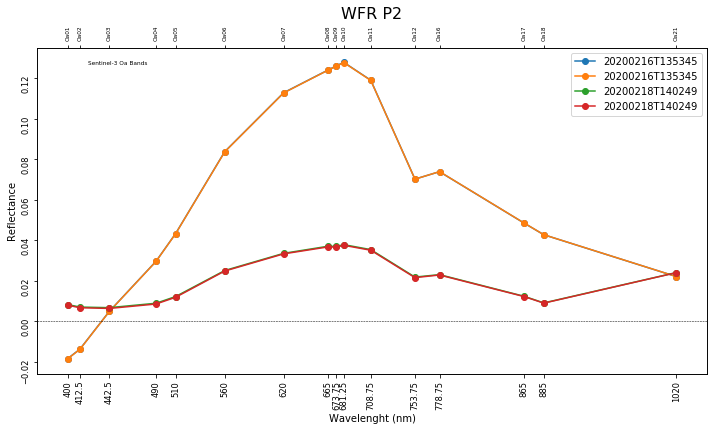

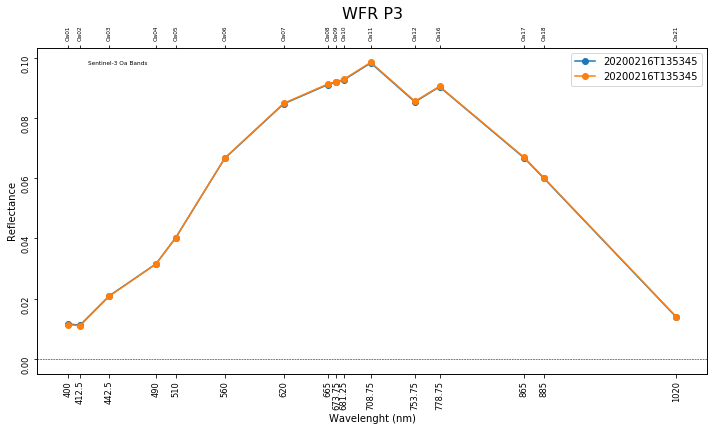

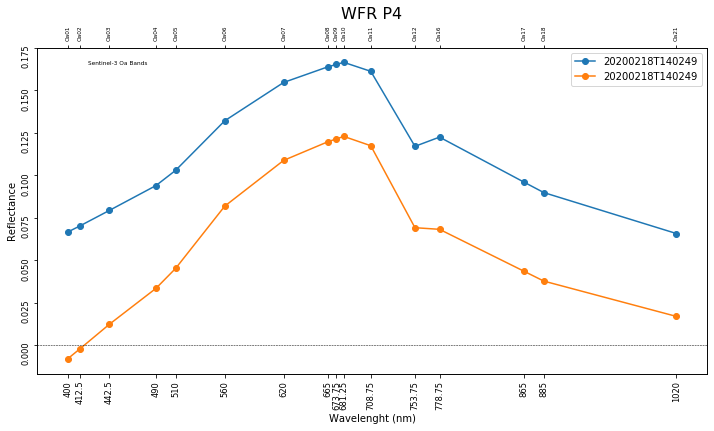

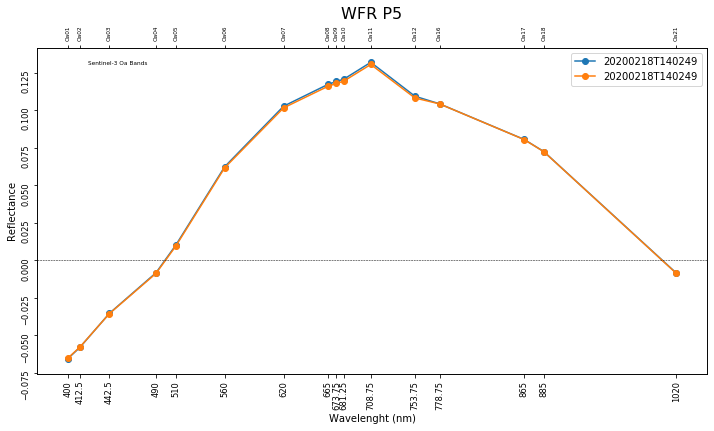

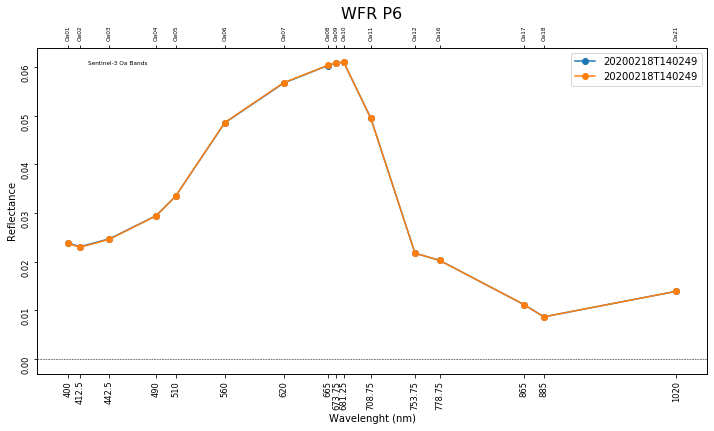

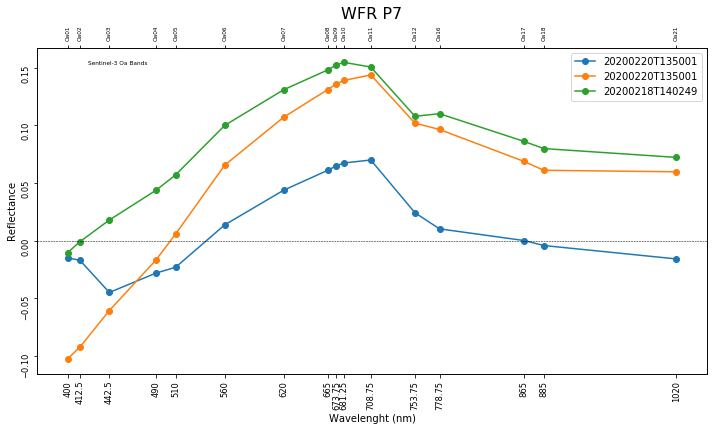

List WFR P8 is empty
List WFR P9 is empty


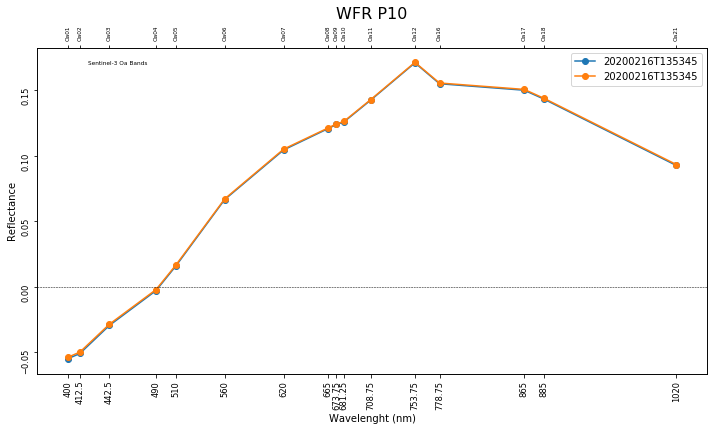

In [190]:
# create a list with the value in (nm) of the 16 Sentinel-3 bands for L2 products.
s3bandstick = list(exp.s3_bands_l2.values())

# create a list with the name of the 16 Sentinel-3 bands for L2 products.
s3bandsticklabel = list(exp.s3_bands_l2.keys())

for i,px in enumerate(corrigir):
    custom_reflectance_plot(list_of_points=px, 
                            figure_title=f'WFR P{i+1}', 
                            s3_bands_tick = s3bandstick, 
                            s3_bands_tick_label = s3bandsticklabel,
                            save_title=f'P{i+1}.png')

## Generating a ms-excel spreadsheet from a pandas dataframe

In [193]:
speadsheet = pd.DataFrame(corrigir)

speadsheet.to_excel('corrigir.xlsx', sheet_name='radiance', index=False)

In [194]:
import pprint 

pp = pprint.PrettyPrinter(indent=4)

pp.pprint(corrigir)

[   [   {   'Img': '20200216T135345',
            'Lat': -2.9856994542458475,
            'Lon': -58.14970549294257,
            'Point': 1,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked]},
        {   'Img': '20200216T135345',
            'Lat': -2.9856994542458475,
            'Lon': -58.14970549294257,
            'Point': 1,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
   

            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked]},
        {   'Img': '20200218T140249',
            'Lat': -3.606902502063587,
            'Lon': -58.9607318793036,
            'Point': 3,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                      

    [   {   'Img': '20200216T135345',
            'Lat': -6.9713248552570795,
            'Lon': -60.5362264724846,
            'Point': 6,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked]},
        {   'Img': '20200216T135345',
            'Lat': -6.9713248552570795,
            'Lon': -60.5362264724846,
            'Point': 6,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
     

            'Point': 8,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked]},
        {   'Img': '20200218T140249',
            'Lat': -3.4793143118916987,
            'Lon': -64.4411701650366,
            'Point': 8,
            'Rad': [   masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       masked,
                       maske